## Exploring confound regressors

This script explores confound regressors variability (measured as standard deviation) across subjects. It also shows correlation between different coonfounds for each subjects. It exports filtered confounds for denoising pipeline `24HMPCSFWM` as `.mat` file used by SPM to perform signal deconvolution.

---
**Last update**: 25.08.2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

from scipy import io
from bids import BIDSLayout
from nilearn.input_data import NiftiSpheresMasker

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data                    

In [2]:
path_bids = os.path.join(path_root, 'data/main_fmri_study')
path_timeries = os.path.join(path_root, 
                             'data/main_fmri_study/derivatives/ppi/timeseries')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_volumes = 730
n_confounds = 32

In [3]:
layout = BIDSLayout(
    root=path_bids,
    derivatives=True,
    validate=True,
    index_metadata=False
)

conf_filter = {
    'extension': 'tsv',
    'desc': 'confounds',
    'return_type': 'filename'
}

conf_files = {}

for task_dict in [{'task': 'prlrew'}, {'task': 'prlpun'}]:
    conf_filter.update(task_dict)
    conf_files[task_dict['task']] = layout.get(**conf_filter)

In [4]:
confounds_filtered_aggregated = np.zeros(
    (n_subjects, n_conditions, n_volumes, n_confounds))

for con_idx, con_name in enumerate(meta['dim2']):    
    for sub_idx in range(n_subjects):
        
        conf_fname = conf_files[f'prl{con_name}'][sub_idx]

        # Read confounds, filtering & save confounds
        conf_df = pd.read_csv(conf_fname, sep='\t')
        conf_df = conf_df.filter(regex='rot|trans|csf|white_matter')
        conf_df = conf_df.reindex(sorted(conf_df.columns), axis=1)
        conf_df = conf_df.fillna(0)

        confounds_filtered_aggregated[sub_idx][con_idx] = conf_df

conf_names = conf_df.columns
        
# Save for further PPI analysis
io.savemat(os.path.join(path_timeries, 'confounds_pipeline-24HMPCSFWM.mat'),
           {'confounds_filtered_aggregated': confounds_filtered_aggregated})

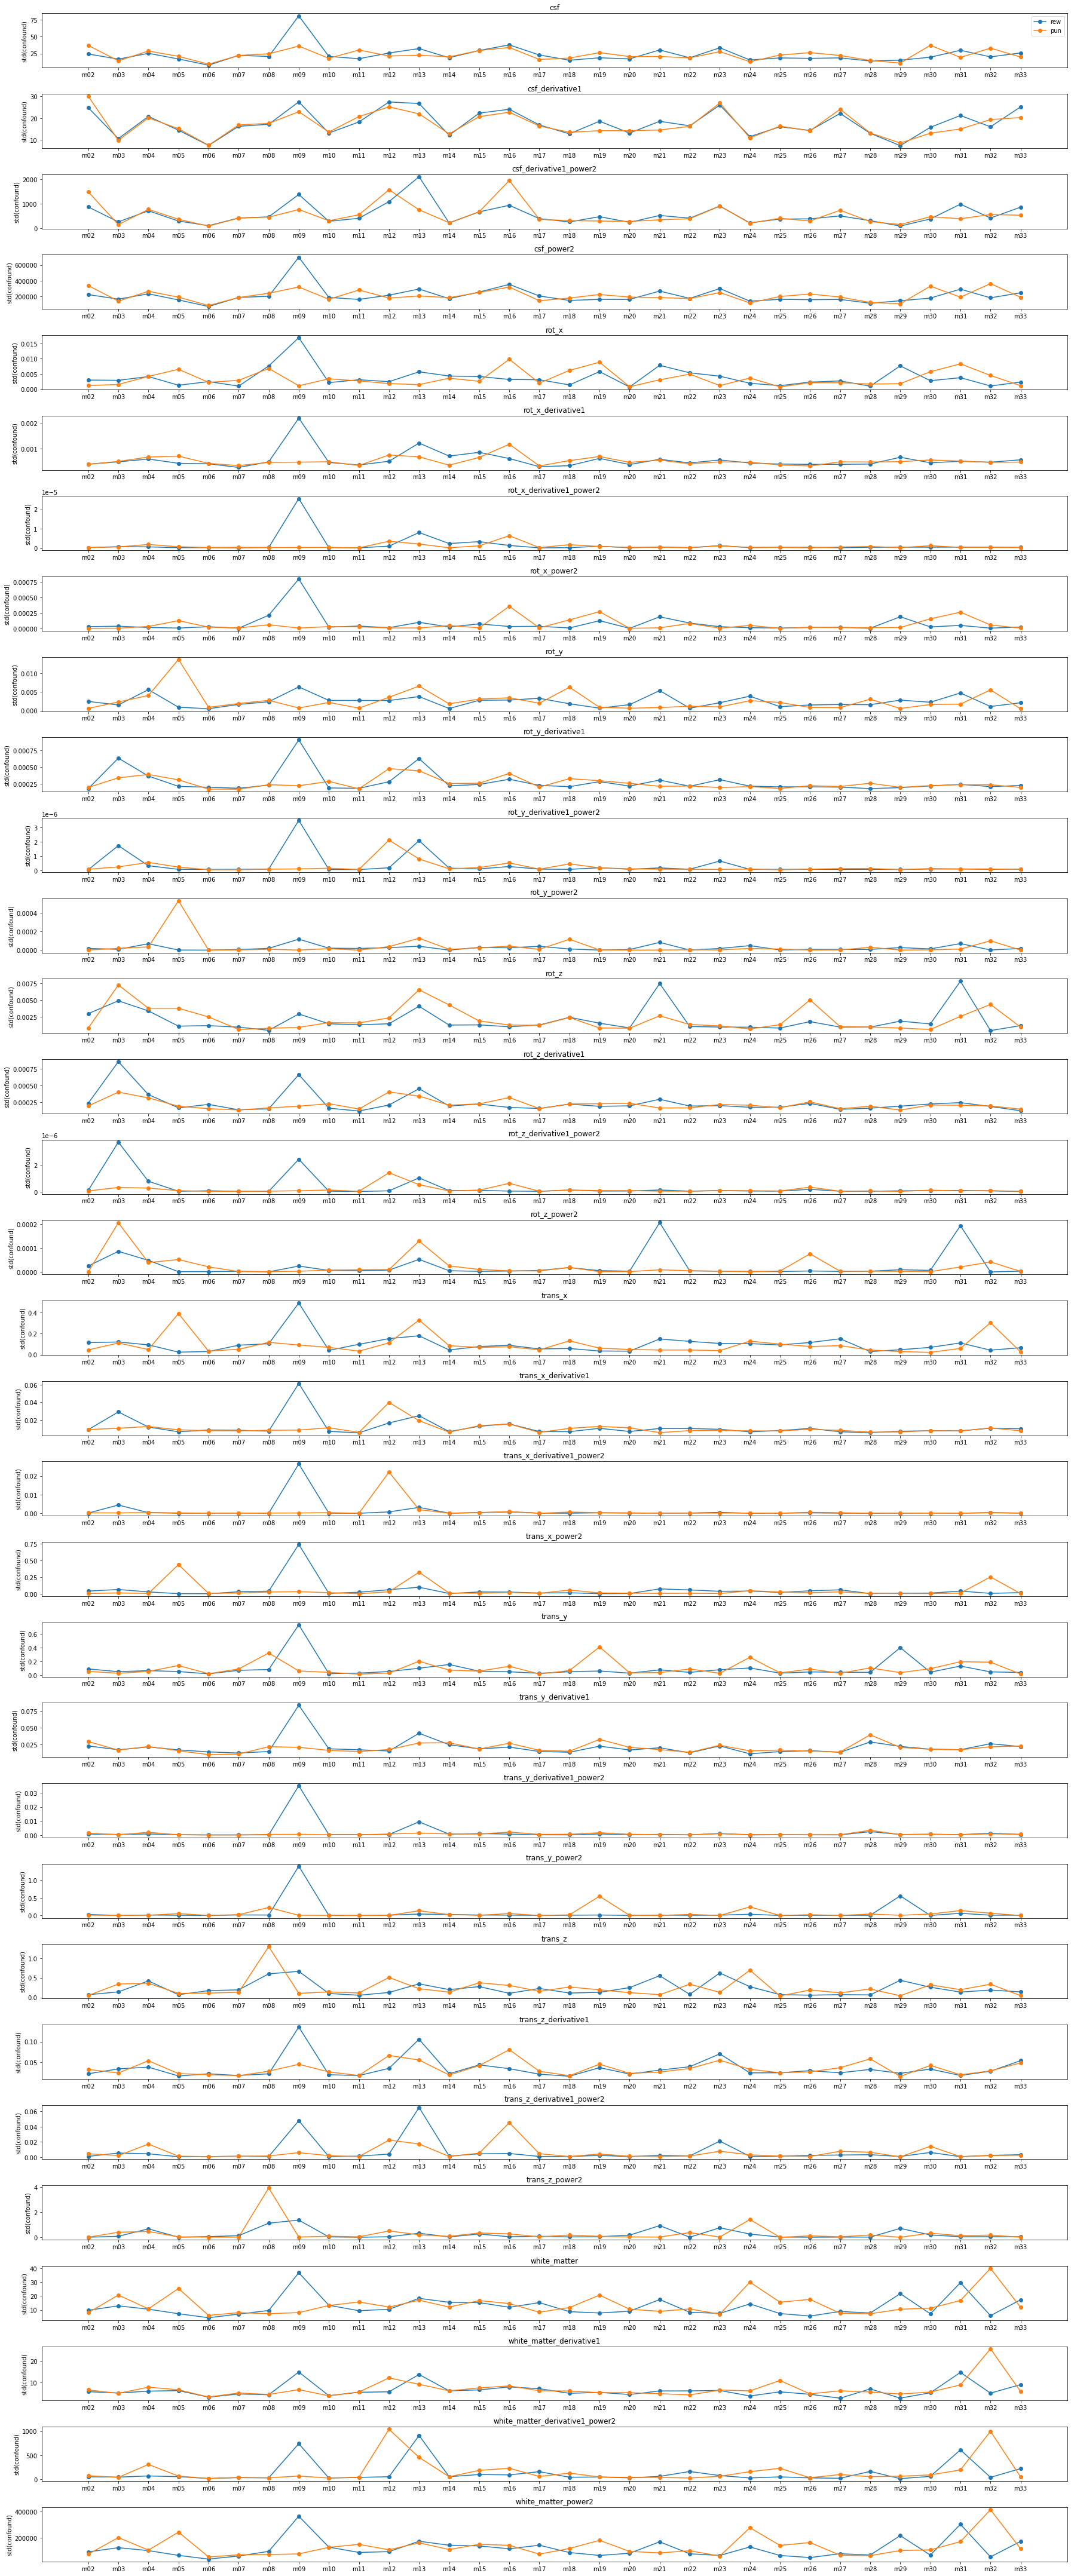

In [5]:
fig, axs = plt.subplots(nrows=n_confounds, figsize=(25, 60))

for conf_idx in range(n_confounds):
    axs[conf_idx].plot(np.std(confounds_filtered_aggregated, axis=2)[:, :, conf_idx], 
                       'o-') 
    axs[conf_idx].set_title(conf_names[conf_idx])
    axs[conf_idx].set_ylabel('std(confound)')
    axs[conf_idx].set_xticks(np.arange(n_subjects))
    axs[conf_idx].set_xticklabels(meta['dim1'])
    
axs[0].legend(('rew', 'pun'))
plt.tight_layout()

In [6]:
# Calculate correlation between confound regressors
corr_conf_all = np.zeros((n_subjects, n_conditions, n_confounds, n_confounds))
for sub in range(n_subjects):
    for con in range(n_conditions):
        corr_conf_all[sub, con] = np.corrcoef(confounds_filtered_aggregated[sub, con].T)

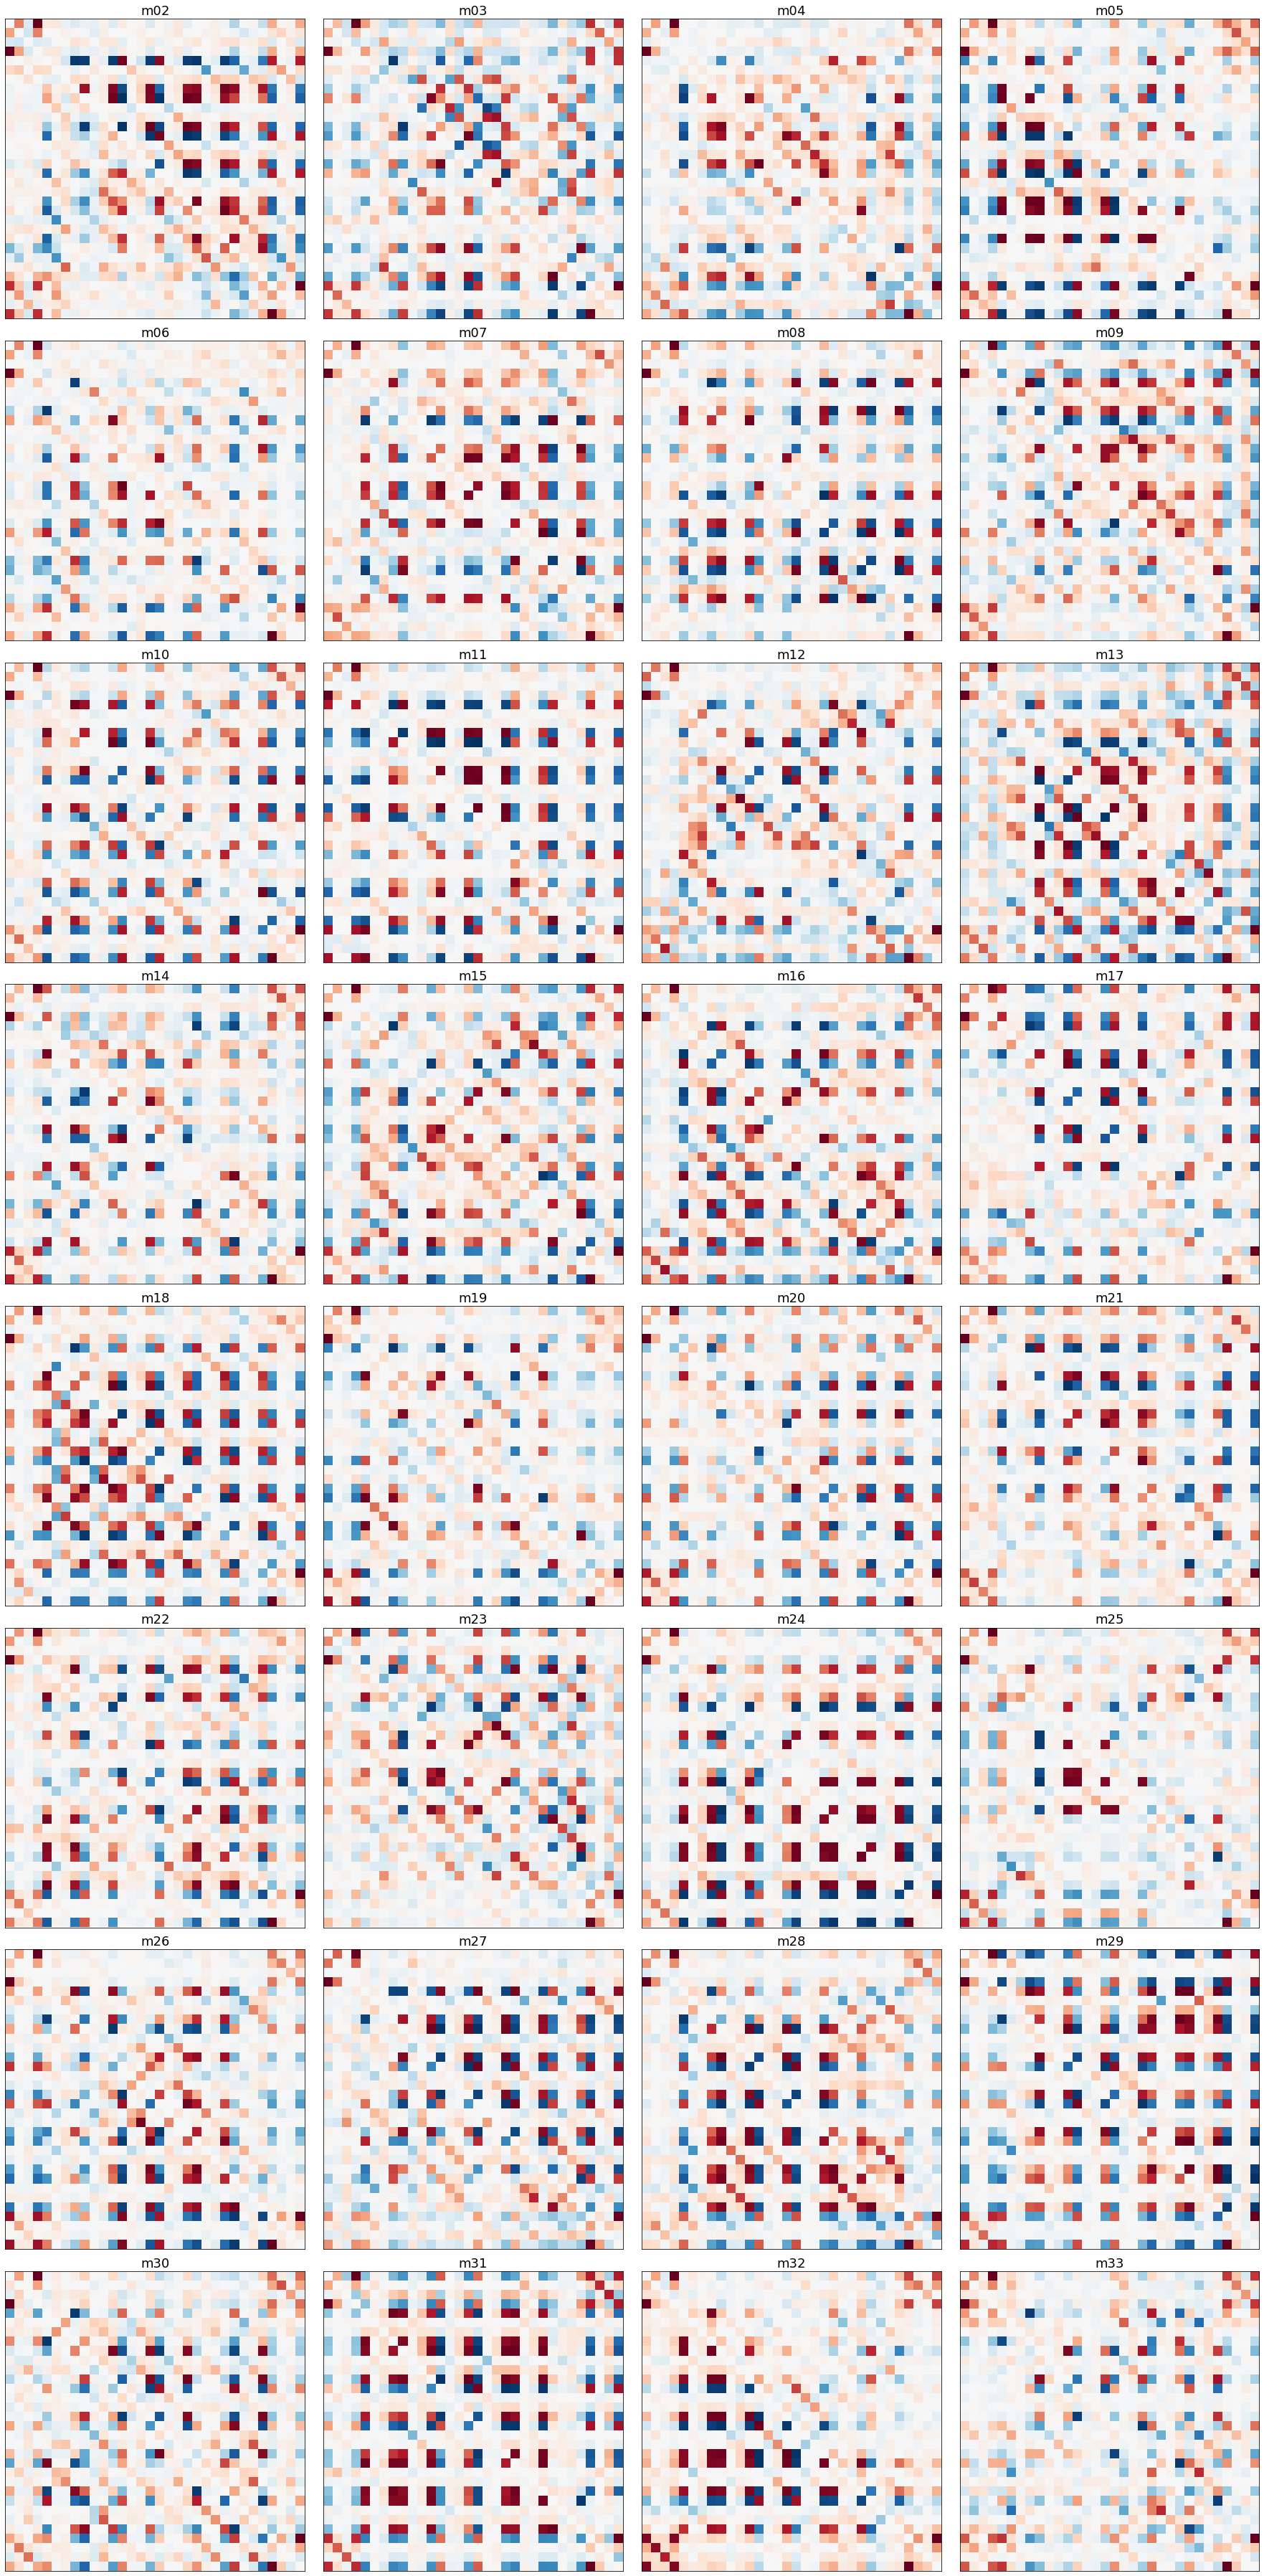

In [7]:
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(25, 50), facecolor='w')

for sub, sub_name in enumerate(meta['dim1']):
    
    A_rew = corr_conf_all[sub, 0]
    A_pun = corr_conf_all[sub, 1]
    
    A = np.triu(A_rew, 1) + np.tril(A_pun, -1)
    
    cur_ax = ax[sub // 4][sub % 4]
    cur_im = cur_ax.imshow(A, cmap='RdBu_r', clim=[-1, 1])
    cur_ax.set_title(f'{sub_name}', fontSize=18)
    cur_ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.tight_layout()